In [1]:
import sys
import os

# Adjust this path to point to the root of your project (the one containing `src/`)
project_root = os.path.abspath("..")  # or "../../" depending on where notebook is
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import gpflow
from gpflow.base import _cast_to_dtype
import tensorflow as tf
import numpy as np
from gpflow.config import default_float
from src.lvmogp.lvmogp_ssvi import LVMOGP_SSVI_Torch
import pathlib as pl
import os
from src.lvmogp.lvmogp_test_functions import TestFun

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

C:\Users\mtret\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\mtret\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
import torch
from src.lvmogp.lvmogp_ssvi import LVMOGP_SSVI_Torch      
from src.gp_dataclasses  import GPSSVIConfig
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

# Quick Notebook Showing how to fit the LVMOGP

In [5]:
seed=1
surface_type = 'linear_relation'
n_new_points=5
n_new_funs = 10
data_type_name = f'two_observed_{n_new_funs}_new'
n_fun = 2 + n_new_funs
total_train = 30*2 + 3 * n_new_points
n_points = [10]*2 + [n_new_points]*n_new_funs
n_train = n_points

set_opt_seed = False

same_points = False
plot_figs = True

train_inducing = True
domain = [0, 2]
latent_dims = 2
latent_dims_lvmogp = 2
observed_dims = 1
max_points = 60

noise = 0.05
n_grid_points = 100
continuous_dims = ['x1', 'x2'][:observed_dims]
lengthscales_x = [0.3, 0.3]
lengthscales_h = [0.4, 0.4, 0.4, 0.4, 0.4, 0.4][:latent_dims]


test_fun = TestFun(domain=domain, seed=seed, n_fun=n_fun,
                   observed_dims=observed_dims, test_type=surface_type, latent_dims=latent_dims, max_points=max_points,
                   noise=noise, n_grid_points=n_grid_points, same_points=same_points, lengthscales_X=lengthscales_x,
                   lengthscales_H=lengthscales_h)

## Generate and Plot the Data

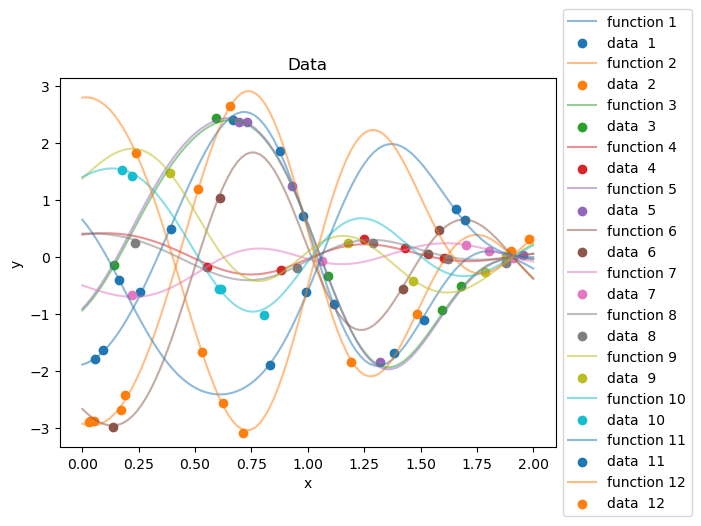

In [6]:
data_X, fun_nos, data_y = test_fun.create_data(n_points=n_points)


if plot_figs:
    test_fun.plot_data(n_points)

## Fit the LVMOGP

Randomly initialise the hyperparameters

In [7]:
torch.set_default_dtype(torch.float64)

# random H initialisation (unchanged values, just Torch)
H_mean = torch.tensor(
    np.random.uniform(-1, 1, (n_fun, latent_dims_lvmogp)),
    dtype=torch.float64
)
H_var  = torch.full_like(H_mean, 1e-6)

# likelihood noise (same formula as before)
lik_variance = np.var(data_y) * 0.01
n_u          =  min(200, len(data_X))                     # number of inducing inputs

Make the LVMOGP

In [8]:
Y_torch  = torch.tensor(data_y , dtype=torch.float64)
X_torch  = torch.tensor(data_X , dtype=torch.float64)
fn_torch = torch.tensor(fun_nos, dtype=torch.float64)

# H_mean = (n_fun, Q)
H_mean_all = torch.tensor(H_mean[fun_nos.flatten()], dtype=torch.float64)  # shape (N, Q)
H_var_all  = torch.full_like(H_mean_all, 1e-6)

model = LVMOGP_SSVI_Torch(
    data        = Y_torch,
    X_data      = X_torch,
    X_data_fn   = fn_torch,
    H_data_mean = H_mean_all,
    H_data_var  = H_var_all,
    num_inducing_variables = n_u,
)


C:\Users\mtret\AppData\Local\Temp\ipykernel_47648\4154977831.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_mean_all = torch.tensor(H_mean[fun_nos.flatten()], dtype=torch.float64)  # shape (N, Q)


In [9]:
from src.gp_dataclasses import (
    GPSSVIConfig,
    LR,
    Rho,
    Training,
    InnerIters,
    InducingConfig,
    InitXDistSsvi,
)


cfg = GPSSVIConfig(
    device="cpu",                    # или "auto"
    debug=False,
    jitter=5e-6,
    max_exp=60.0,
    q_latent=latent_dims_lvmogp,
    init_signal_to_noise_ratio=1.0,
    num_u_samples_per_iter=2,

    lr=LR(
        x=1e-3,
        hyp=1e-3,
        alpha=5e-3,
    ),

    rho=Rho(
        t0=100.0,
        k=0.6,
    ),

    training=Training(
        batch_size=min(128, len(data_X)),
        total_iters=5,
        inner_iters=InnerIters(
            start=40,
            after=30,
            switch=50,
        ),
    ),

    inducing=InducingConfig(
        n_inducing=n_u,
        selection="perm",
        seed=19,
    ),

    init_latent_dist=InitXDistSsvi(
        method="default",
        custom_path=None,
    ),
)


Train it

In [10]:
results = model.ssvi_train(cfg)          # trains in Torch

Config auto selected device: cpu
num_u_samples_per_iter: 2
snr: 1.0


 20%|█████████████                                                    | 1/5 [00:02<00:09,  2.34s/it]


DATASET FULL ELBO @   1: -1.1715e+03  LL=-1.2554e+02  KL_X=6.4946e+02  KL_U=3.9650e+02


 40%|██████████████████████████                                       | 2/5 [00:04<00:06,  2.04s/it]


DATASET FULL ELBO @   2: -9.3547e+02  LL=-1.2359e+02  KL_X=6.4555e+02  KL_U=1.6634e+02


 80%|████████████████████████████████████████████████████             | 4/5 [00:08<00:02,  2.00s/it]


DATASET FULL ELBO @   4: -8.2377e+02  LL=-1.2480e+02  KL_X=6.3796e+02  KL_U=6.1010e+01


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  2.00s/it]


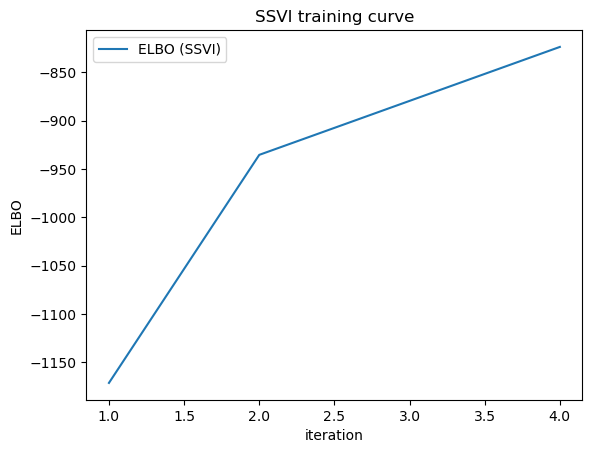

In [11]:
import matplotlib.pyplot as plt

iters = results["elbo_iters"]    # list saved by the trainer
elbo  = results["elbo_vals"]     # same as before

plt.plot(iters, elbo, label="ELBO (SSVI)")
plt.xlabel("iteration")
plt.ylabel("ELBO")
plt.title("SSVI training curve")
plt.legend()
plt.show()

Predict on new points

In [13]:
x_new  = torch.linspace(domain[0], domain[1], 100,
                        dtype=torch.get_default_dtype(), device=model.DEV).view(-1, 1)   # (100,1)
xs_new = x_new.repeat(n_fun, 1)                                           # (100*n_fun, 1)

fun_ids        = torch.unique(fn_torch, sorted=True)                      # (n_fun,)
X_data_fun_new = torch.cat([ torch.full((len(x_new),), fid,
                                        dtype=torch.long, device=model.DEV)
                             for fid in fun_ids ])                        # (100*n_fun,)
fun_nos_new    = X_data_fun_new                                           # alias

H_mean_vect = model.H_mean[fun_nos_new]                # (100*n_fun , Q)
H_var_vect  = model.H_log_s2.exp()[fun_nos_new]        # (100*n_fun , Q)

Xnew_mean = torch.cat([xs_new,                H_mean_vect], dim=1)        # (N*, D_x+Q)
Xnew_var  = torch.cat([torch.zeros_like(xs_new), H_var_vect], dim=1)      # (N*, D_x+Q)

lvm_mu, lvm_sig2 = model.predict_y((Xnew_mean, Xnew_var))                # (N*, D_out) each

Plot the predictions and the latent coordinates

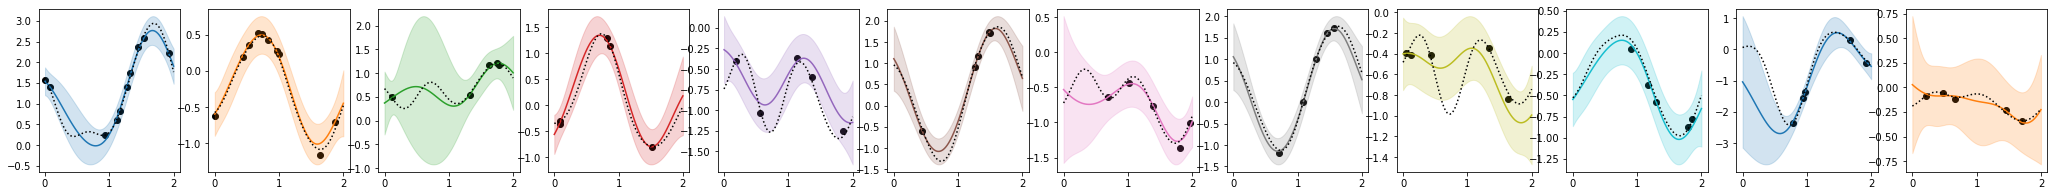

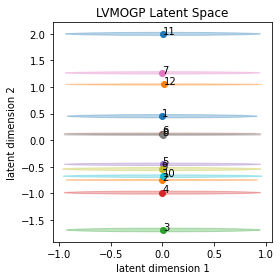

In [15]:
from matplotlib.patches import Ellipse
ys_new = []
for fun in test_fun.functions:
    y_new, _ = fun.predict_y(x_new)
    ys_new.append(y_new)


fig, axs = plt.subplots(1, ncols=n_fun, figsize=( 3 *n_fun, 3))
ax = axs.flatten()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 100
for i, fun_no in enumerate(np.unique(fun_nos)):
    idx = np.where(fun_nos_new == fun_no)[0]
    ax[i].plot(x_new, lvm_mu.numpy()[idx], color=colors[i])
    ax[i].scatter(test_fun.xs[i][:n_points[i]], test_fun.ys[i][:n_points[i]], color='k')
    ax[i].plot(x_new, ys_new[i], linestyle=':', color='k')
    ax[i].fill_between(x_new.flatten(), lvm_mu.numpy()[idx].flatten() + 2 *np.sqrt(lvm_sig2.numpy()[idx].flatten()),
                       lvm_mu.numpy()[idx].flatten() - 2 * np.sqrt(lvm_sig2.numpy()[idx].flatten()),
                       alpha=0.2, color=colors[i])
    # ax[i].scatter(lvmogp.inducing_variable.Z.numpy()[:, 0],
    #               [-2.95] * len(lvmogp.inducing_variable.Z.numpy()), color='k', marker='x')

plt.show()


fig = plt.figure(figsize=(4, 4))
axsH = plt.gca()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 100
for i, H_coord in enumerate(lvmogp.H_data_mean.numpy()):
    axsH.scatter(H_coord[0], H_coord[1], label=f'{i + 1}', color=colors[i])
    axsH.annotate(f'{i + 1}', (H_coord[0], H_coord[1]))
    axsH.set_title(f"LVMOGP Latent Space")
    axsH.set_xlabel(f'latent dimension 1')
    axsH.set_ylabel(f'latent dimension 2')
    circle1 = Ellipse((H_coord[0], H_coord[1]),
                      1.95 * np.sqrt(lvmogp.H_data_var.numpy()[i, 0]),
                      1.95 * np.sqrt(lvmogp.H_data_var.numpy()[i, 1])
                      , color=colors[i], alpha=0.3, zorder=0)
    # axsH.scatter(lvmogp.inducing_variable.Z[:, 1],lvmogp.inducing_variable.Z[:, 2], color='k', marker='x')
    axsH.add_patch(circle1)
plt.tight_layout()

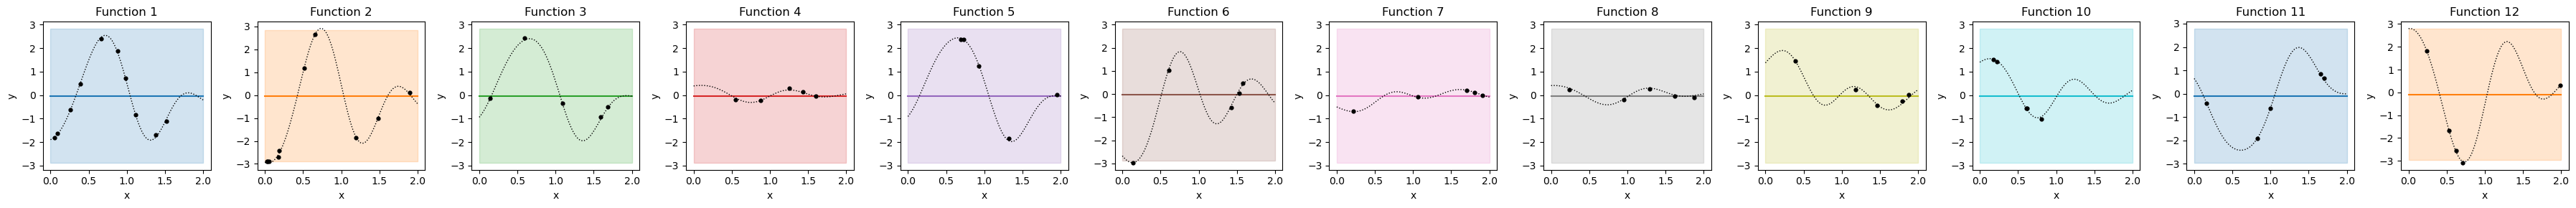

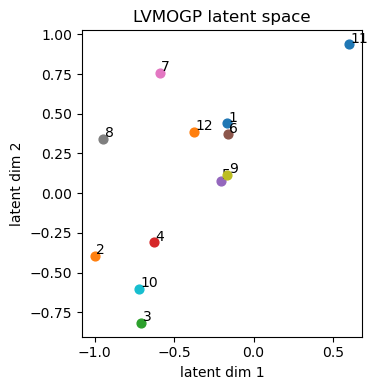

In [17]:
from matplotlib.patches import Ellipse

# SETTINGS  
n_fun        = len(test_fun.functions)          # number of functions
pts_per_fun  = 100                              # x-points per function
palette      = (plt.rcParams['axes.prop_cycle']
                .by_key()['color']) * 10        # plenty of distinct colours

# ---------- 1. Ground-truth curves  -----------------------------------
ys_new = []
for f in test_fun.functions:
    y_tf, _ = f.predict_y(x_new.cpu().numpy())              # GPflow → NumPy
    ys_new.append(torch.from_numpy(y_tf.numpy())            # NumPy → Torch
                       .to(dtype=x_new.dtype,
                           device=x_new.device))

# ---------- 2. LVMOGP predictions vs. ground-truth  -------------------
fig, axs = plt.subplots(1, ncols=n_fun, figsize=(3*n_fun, 3))
axs      = axs.flatten()

x_np   = x_new.cpu().numpy().flatten()                      # (100,)
mu_np  = lvm_mu .cpu().numpy().squeeze()                    # (n_fun*100,)
s2_np  = lvm_sig2.cpu().numpy().squeeze()                   # (n_fun*100,)

mu_np = mu_np.reshape(n_fun, pts_per_fun)                   # (n_fun,100)
s2_np = s2_np.reshape(n_fun, pts_per_fun)

for i in range(n_fun):
    mu_i, s2_i = mu_np[i], s2_np[i]

    axs[i].plot(x_np, mu_i, color=palette[i], lw=1.5)       # prediction
    axs[i].fill_between(x_np,                               # 95 % CI
                        mu_i + 2.0*np.sqrt(s2_i),
                        mu_i - 2.0*np.sqrt(s2_i),
                        alpha=0.20, color=palette[i])

    axs[i].scatter(test_fun.xs[i][:n_points[i]],            # training pts
                   test_fun.ys[i][:n_points[i]],
                   color='k', s=12, zorder=3)

    axs[i].plot(x_np,                                       # ground-truth
                ys_new[i].cpu().numpy().flatten(),
                linestyle=':', color='k', lw=1)

    axs[i].set_title(f'Function {i+1}')
    axs[i].set_xlabel('x');  axs[i].set_ylabel('y')

plt.tight_layout();  plt.show()

# ---------- 3. Latent space (Q = 2)  ----------------------------------
fig, axH = plt.subplots(figsize=(4, 4))

H_mean_np = model.H_mean   .cpu().numpy()        # (N_train,2)
H_var_np  = model.H_log_s2.exp().cpu().numpy()   # (N_train,2)
fn_idx_np = model.fn_idx    .cpu().numpy().astype(int)

# choose one training point per function for clarity
rep_idx    = [np.where(fn_idx_np == i)[0][0] for i in range(n_fun)]
H_mean_fun = H_mean_np[rep_idx]                 # (n_fun,2)
H_var_fun  = H_var_np [rep_idx]                 # (n_fun,2)

for i, (m, v) in enumerate(zip(H_mean_fun, H_var_fun)):
    axH.scatter(*m, color=palette[i], s=40, zorder=3)
    axH.annotate(str(i+1), m + 0.01)

    # axis-aligned 95 % ellipse  (around 1.95 sigma)
    ell = Ellipse(xy=m,
                  width  = 1.95*np.sqrt(v[0]),
                  height = 1.95*np.sqrt(v[1]),
                  angle  = 0,
                  alpha  = 0.30,
                  color  = palette[i])
    axH.add_patch(ell)

axH.set_title('LVMOGP latent space')
axH.set_xlabel('latent dim 1');  axH.set_ylabel('latent dim 2')
axH.set_aspect('equal', adjustable='box')
plt.tight_layout();  plt.show()
